In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [14]:
from dataset import GermanCreditDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [15]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

dataset = GermanCreditDataset()
input_dim = dataset.get_dataframe().shape[1] - 1
seed = None
# torch.manual_seed(seed)

counterfactual_algorithms = [
    'DiCE',
    # 'DisCount',
    'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        # (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        "CF_OTMatch",
        # "CF_OTMatch_0.5", 
        # "CF_OTMatch_1.0",
        # "CF_OTMatch_5.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 50
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not working.")


INFO:root:PyTorchDNN accuracy: 0.7266666666666667
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchDNN counterfactuals with DiCE
100%|██████████| 50/50 [04:06<00:00,  4.93s/it]
INFO:root:Computing PyTorchDNN counterfactuals with KNN


In [16]:
logger.info("\n\n------Compute Action Policies------")
experiment.compute_intervention_policies(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Action Policies------
INFO:root:Shapley values for PyTorchDNN using CF_UniformMatch with counterfactual by DiCE


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Shapley values for PyTorchDNN using CF_SingleMatch with counterfactual by DiCE
INFO:root:Shapley values for PyTorchDNN using CF_OTMatch with counterfactual by DiCE
INFO:root:Shapley values for PyTorchDNN using CF_UniformMatch with counterfactual by KNN


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Shapley values for PyTorchDNN using CF_SingleMatch with counterfactual by KNN
INFO:root:Shapley values for PyTorchDNN using CF_OTMatch with counterfactual by KNN


In [17]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400],
    trials_num=10,
    replace=False
)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Action policy for PyTorchDNN using CF_UniformMatch with counterfactual by DiCE
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 10/10 [00:00<00:00, 49.69it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 10/10 [00:00<00:00, 101.00it/s]
INFO:root:Computing median_difference for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 10/10 [00:00<00:00, 91.76it/s]
INFO:root:Action policy for PyTorchDNN using CF_SingleMatch with counterfactual by DiCE
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 10/10 [00:00<00:00, 42.83it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 10/10 [00:00<00:00, 79.36it/s]
INFO:root:Computing median_difference for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 10/10 [00:00<00:00, 73.40it/

In [18]:
# from copy import deepcopy
# distance_results_backup = deepcopy(experiment.distance_results)

In [19]:
# import pickle 
# with open(f"pickles/{dataset.name}_distance_results.pickle", "rb") as input_file:
#     experiment.distance_results.update(pickle.load(input_file))

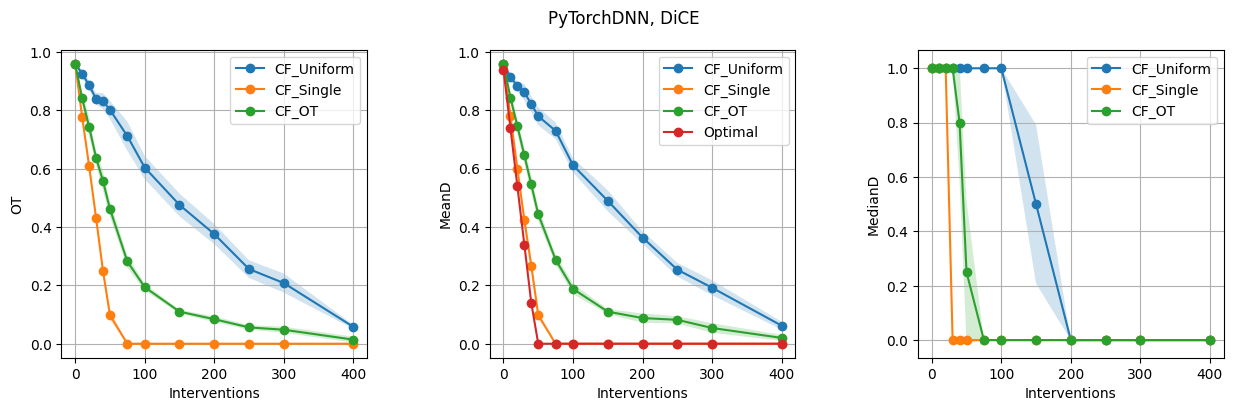

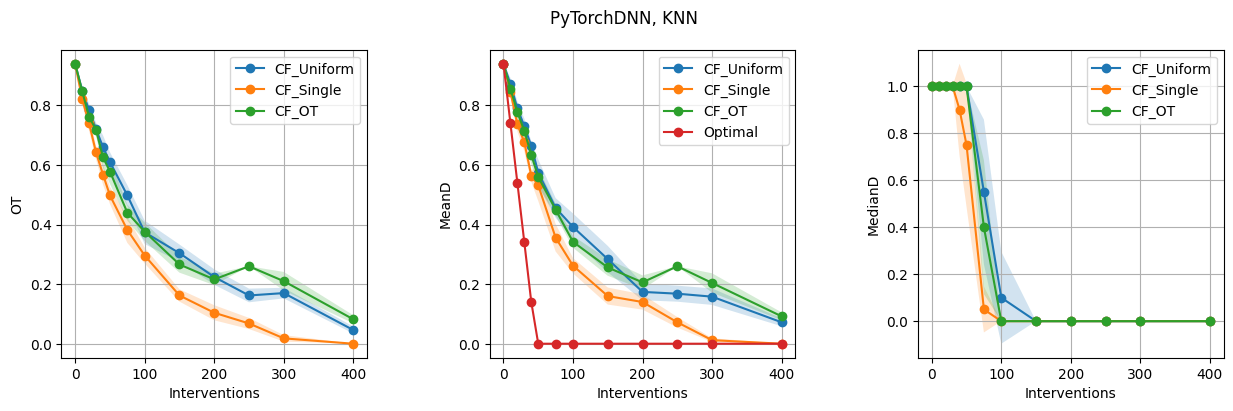

In [20]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)

In [21]:
# import pickle
# with open(f"pickles/{dataset.name}_distance_results.pickle", "wb") as output_file:
#     pickle.dump(experiment.distance_results, output_file)

In [22]:
# from experiments.baseline import OptimalMeanDifference

# model_name = model.classifier.__class__.__name__

# X_factual = model_counterfactuals[model_name]['DiCE']['X_factual']
# X_counterfactual = model_counterfactuals[model_name]['DiCE']['X']

# optimal_mean_difference = OptimalMeanDifference(model, X_factual, X_counterfactual)
# optimal_mean_difference.solve_problem(C=0)

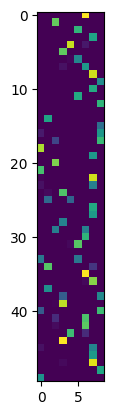

In [28]:
plt.imshow(experiment.policies['PyTorchDNN']['DiCE']['CF_SingleMatch'])

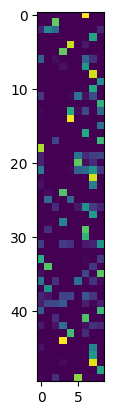

In [29]:
plt.imshow(experiment.policies['PyTorchDNN']['DiCE']['CF_OTMatch'])

In [31]:
from experiments.policy import *

In [48]:
X_factual = model_counterfactuals['PyTorchDNN']['KNN']['X_factual']
X_counterfactual = model_counterfactuals['PyTorchDNN']['KNN']['X']

In [49]:
model.classifier

PyTorchDNN(
  (fc1): Linear(in_features=9, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [50]:


policy = CounterfactualOptimalTransportPolicy(model, X_factual, X_counterfactual)
policy.compute_policy();

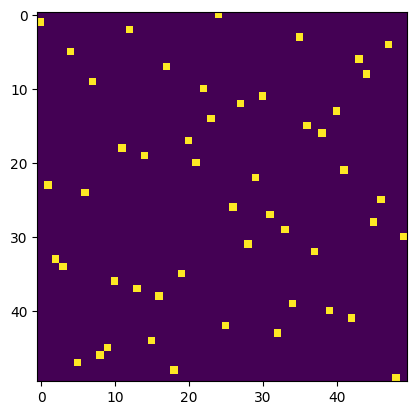

In [51]:
plt.imshow(policy.ot_plan)

In [52]:
policy.ot_plan

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.02, 0.  ]])